---
layout: post
title:  "A/B Test Significance in Python"
desc: "Using Python to determine just how confident we are in our A/B test results"
date: 2020-01-12
categories: [tutorial]
tags: [plotting]
loc: 'tutorials/abtests/'
math: true
---

!!!replace

Recently I was asked to talk about A/B tests for my [Python for Statistical Analysis course](https://www.udemy.com/python-for-statistical-analysis/?couponCode=COSMICCODING2). Given my travel schedule, leaving me bereft of my microphone, I thought it would be better to condense down AB tests into a tutorial or two.

## What is an AB test?

Imagine you're in charge of a website to optimise sales. You have the current version of the website, but aren't happy with it. The "Buy now" button is not obvious to the user, it's hidden away, so you want to try making it bigger and brighter, maybe that will increase conversion. But you also care about statistical rigour (an odd combination to be sure). So you set up your website so that half the people are directed to the old website, and half to one where you've made your change. You have data from both, and want to know, with confidence, *"Does the change I made increase conversion?"*.

In [22]:
plt.rc('text', usetex=False)
plt.rc('font', family='sans-serif')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 3)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.frameon'] = False
from cycler import cycler	  
plt.rcParams['axes.prop_cycle'] = (cycler(color=["#673AB7","#03A9F4","#D32F2F","#FFA000"]) + cycler(linestyle=['-', '--', ':', '-.']))


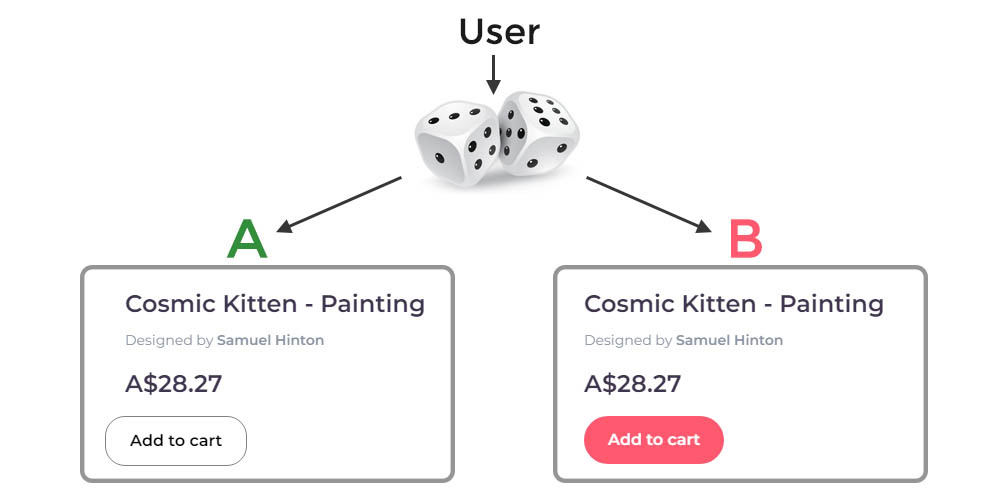

In [51]:
from IPython.display import Image
Image("abtests/abtest.jpg")

This is an A/B test. Often this is used interchangably with the term "split testing", though in general A/B tests test small changes, and split testing might be when you present two entirely different websites to the user.

**Why not just change the website and monitor it for a week?** Good question - by having two sites active at once and randomly directing users to one or the other, you control for all other variables. If one week later puts you the week before Christmas, this will impact sales, and you might draw the wrong conclusion because of these confounding effects.

**Why is it not an A/B/C test?** Well, you can have as many perturbations running as you want, but got to keep the name simple. The more perturbations you try though, the smaller a number of samples you'll have for each case, and the harder it will be to draw statistically significant conclusions.

Now, A/B tests can test anything you want, but common ones are click through/conversion, bounce rate, and how long you spend on the page. For this example, let us assume we want to optimise conversion, which in our case is clicking the "Add to cart" button above. 

Let us assume you have 1000 users, 550 were directed to site A, 450 to site B. In site A, 48 users converted. In site B, 56 users converted. **Is this a statistically significant result?**


In [24]:
num_a, num_b = 550, 450
click_a, click_b = 48, 56
rate_a, rate_b = click_a / num_a, click_b / num_b

## Modelling click through

You can click a button, or not. Two discrete options are available, so this is a textbook binomial distribution, with some unknown rate for site A and site B. We don't know the true click rate, but we can estimate it using our small sample.

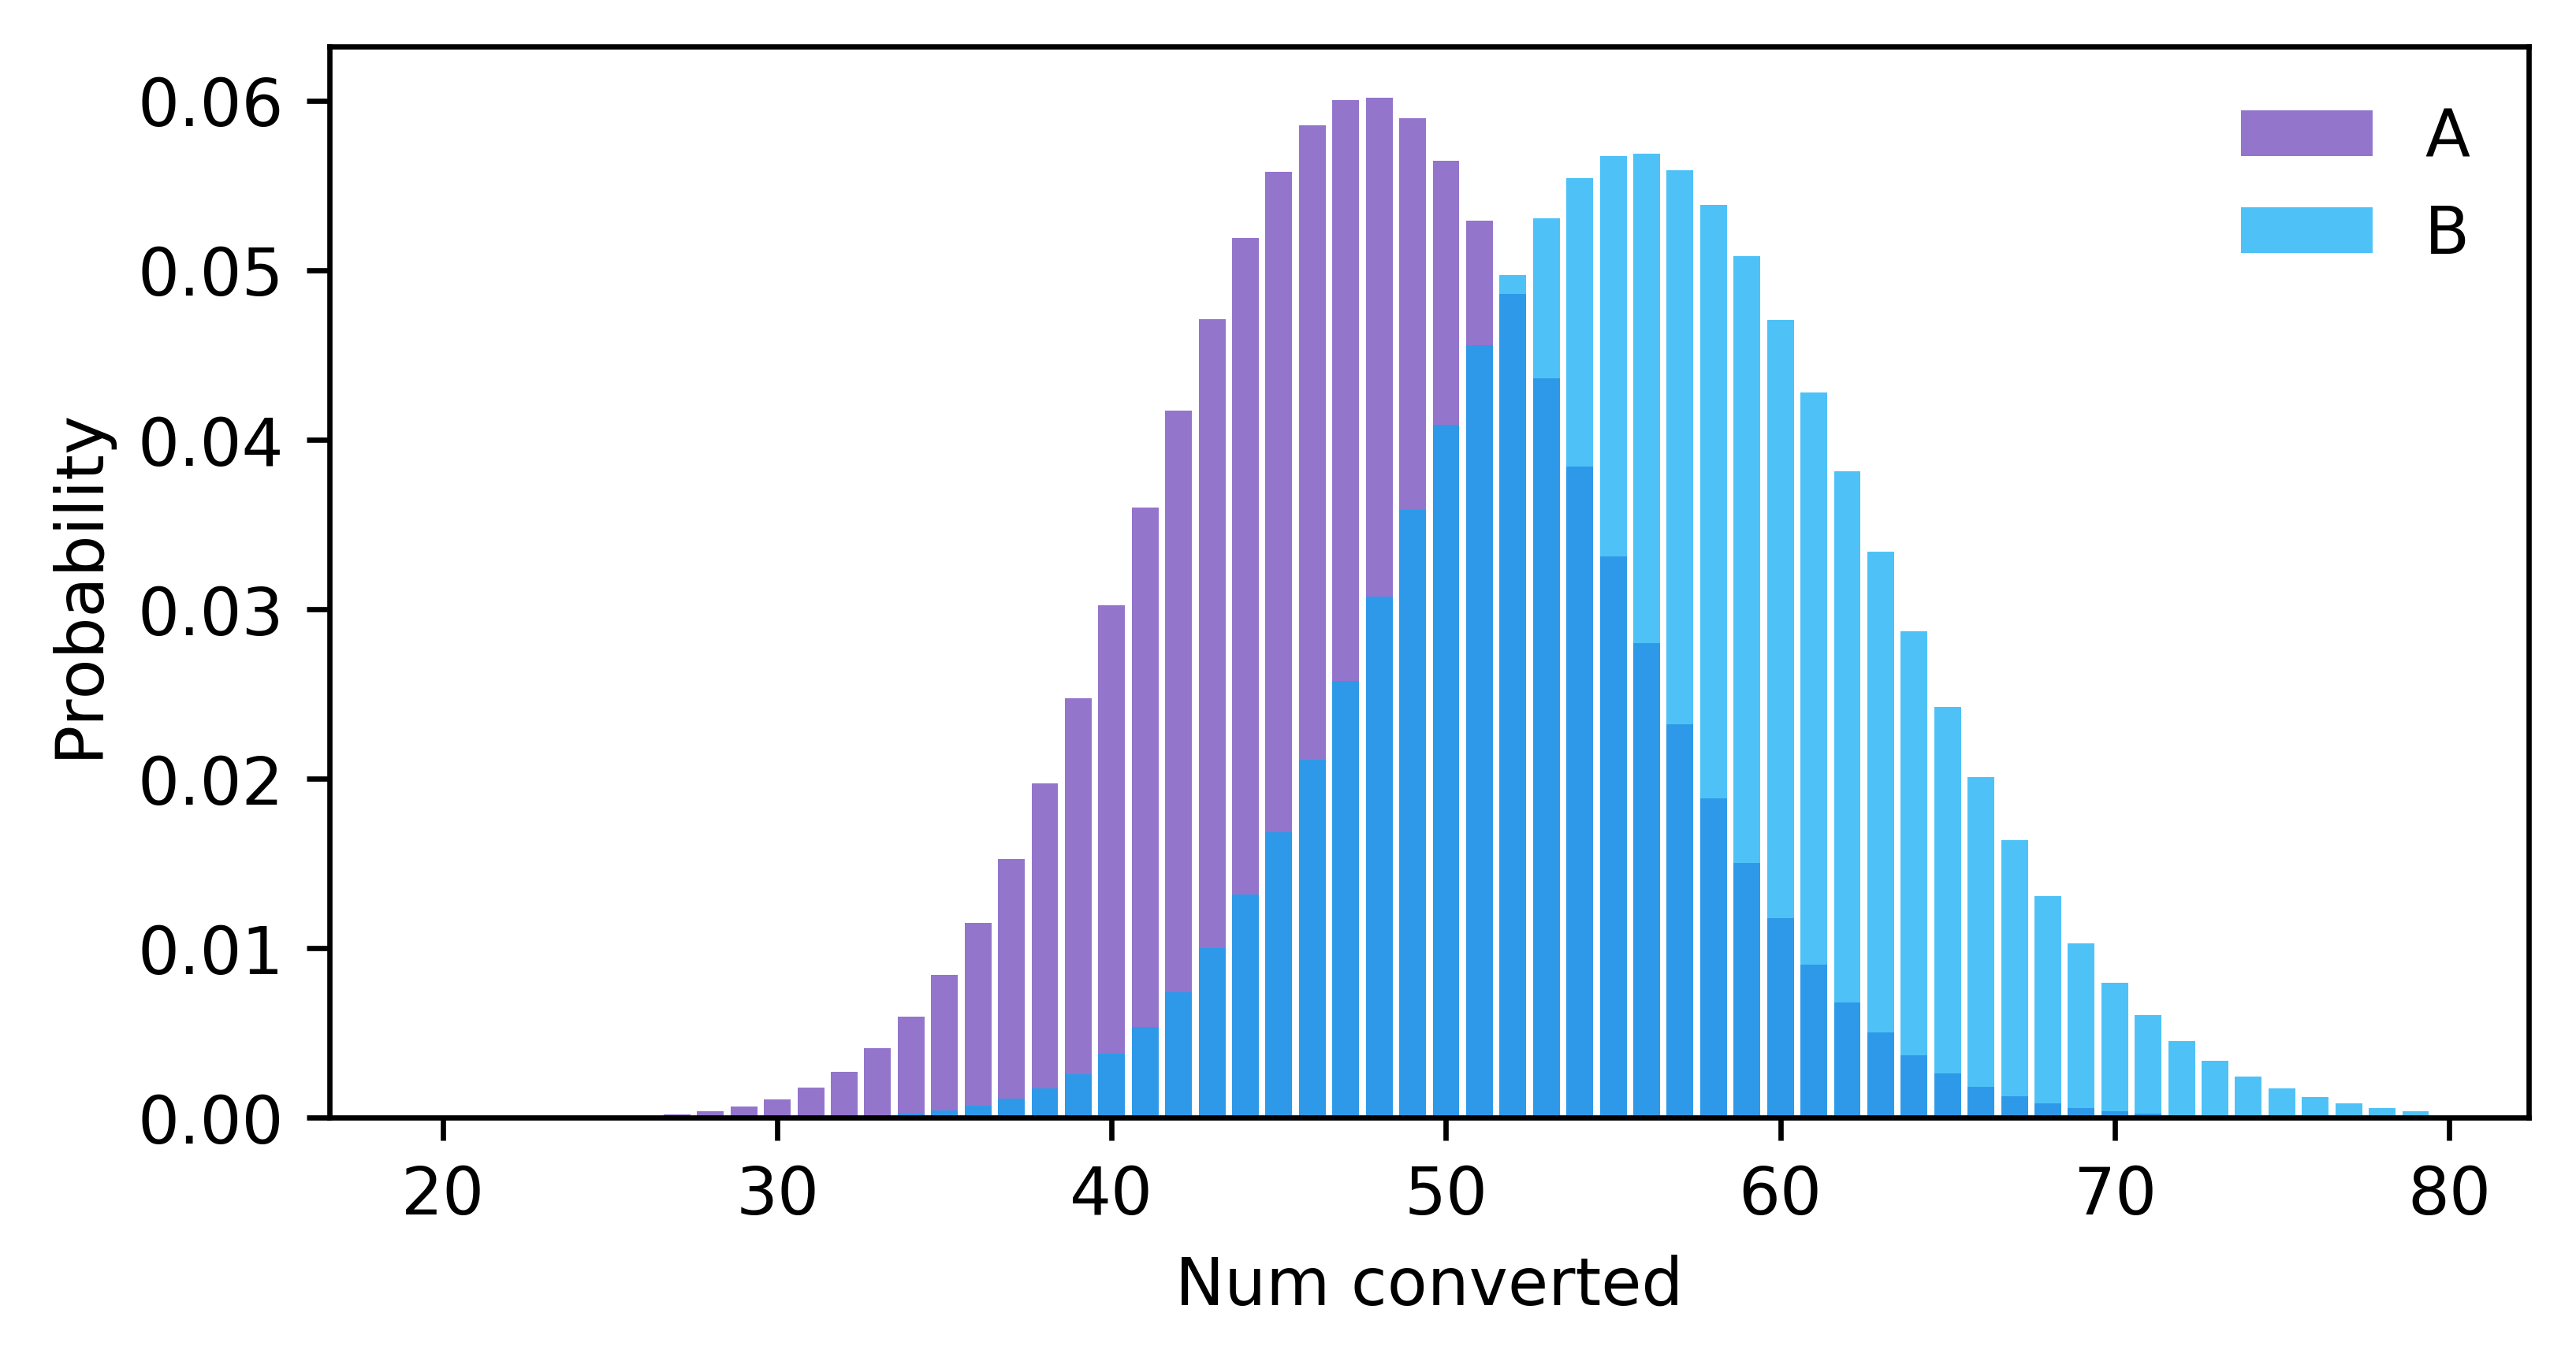

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import binom
import numpy as np

# Determine the probability of having x number of click throughs
clicks = np.arange(20, 80)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)

# Make the bar plots.
plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num converted"); plt.ylabel("Probability");

So we can see here that b has an edge, but its certaintly possible if we pick two random points according to the histograms for A and B, that A might actually be higher than B!

# Let's get normal

Sure, we *can* work with binomial distributions in this case. And Poisson distributions in the "How long were you on the site" case. We could swap for every question... or we can invoke the Central Limit Theorem. As we're interested in the **average** conversion, or **average** time spent on the site, this averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution.

So let's reformulate, [using the normal approximation here](https://en.wikipedia.org/wiki/Binomial_distribution#Normal_approximation):

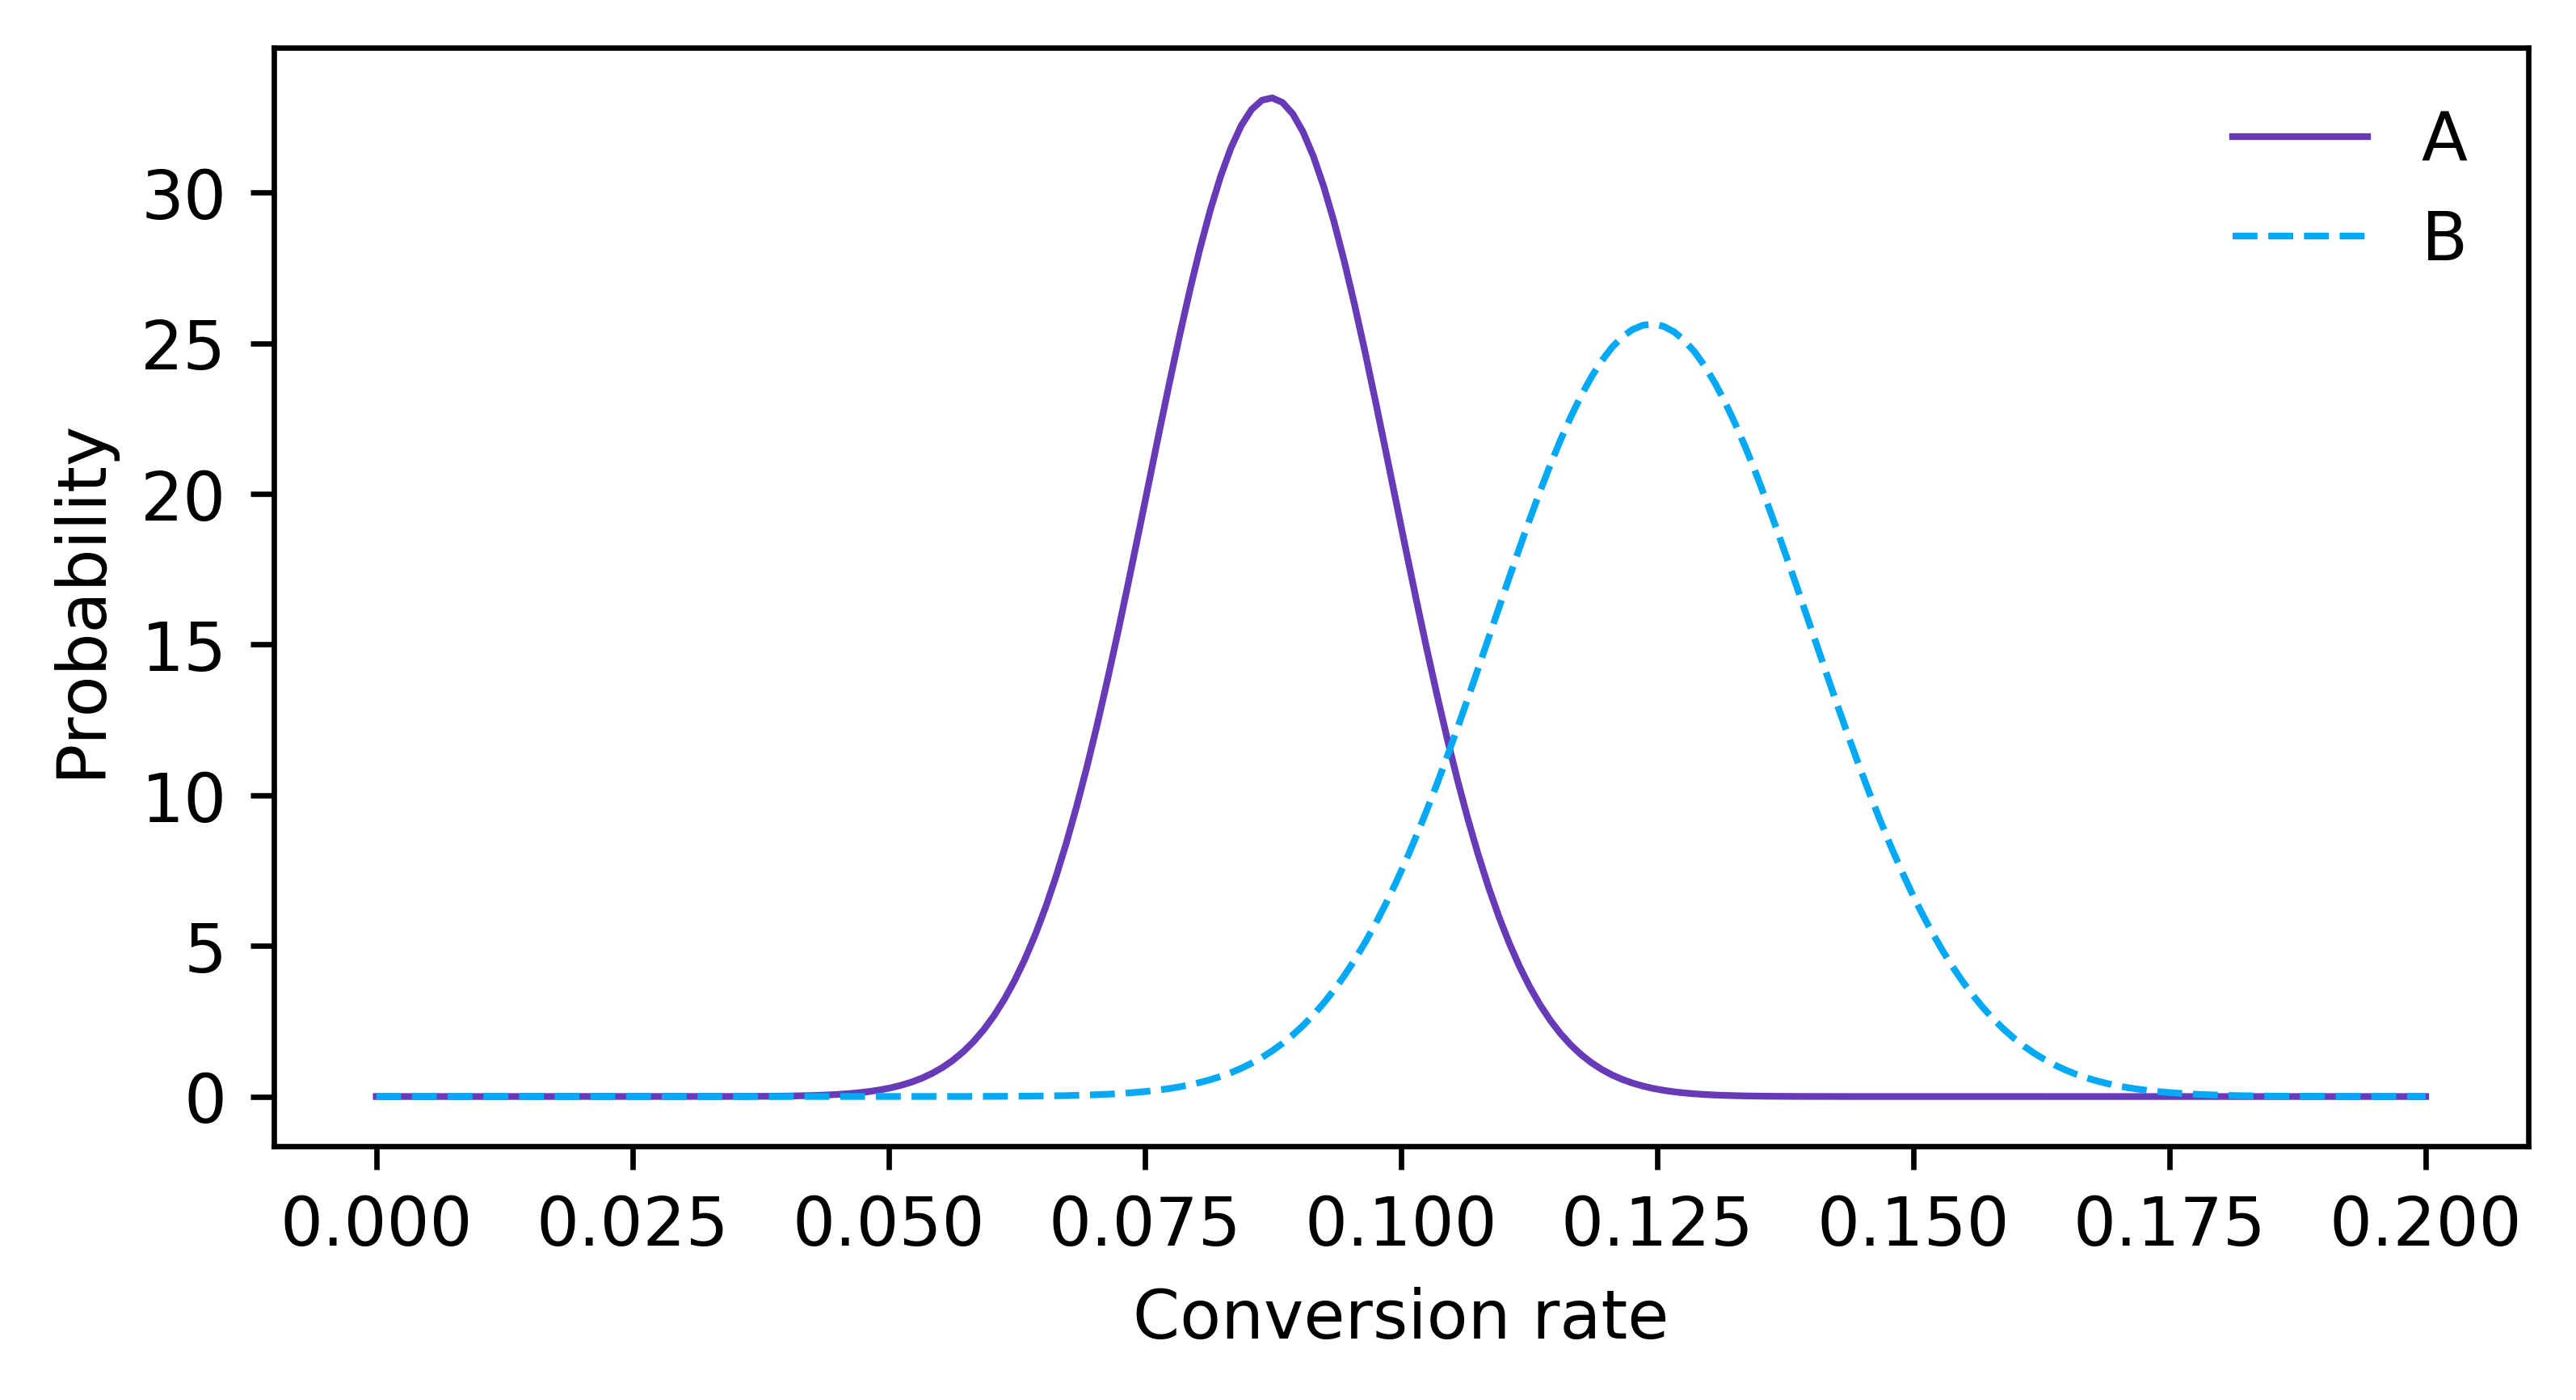

In [27]:
from scipy.stats import norm

# Where does this come from? 
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0, 0.2, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

!!!main

This is also a better plot than the first one, because we've removed the confusing effect of site A and site B having a slightly different number of visitors had. So our question is still the same: What is the chance that a draw from B is higher than a draw from A. Is it significant.

To answer this, let us utilise the handy fact that the sum (or difference) of normally distributed random numbers is also a normal. [See here for the proof](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables), but the math is as follows:

$$ P(b-a) = \mathcal{N}(\mu_B - \mu_A, \sqrt{\sigma_A^2 + \sigma_B^2}) $$

This is simple - take the difference in the means and sum the variance. We'll do two things below: First, get the z-score, and second, plot the proper distribution.

zscore is 1.890, with prob 0.029


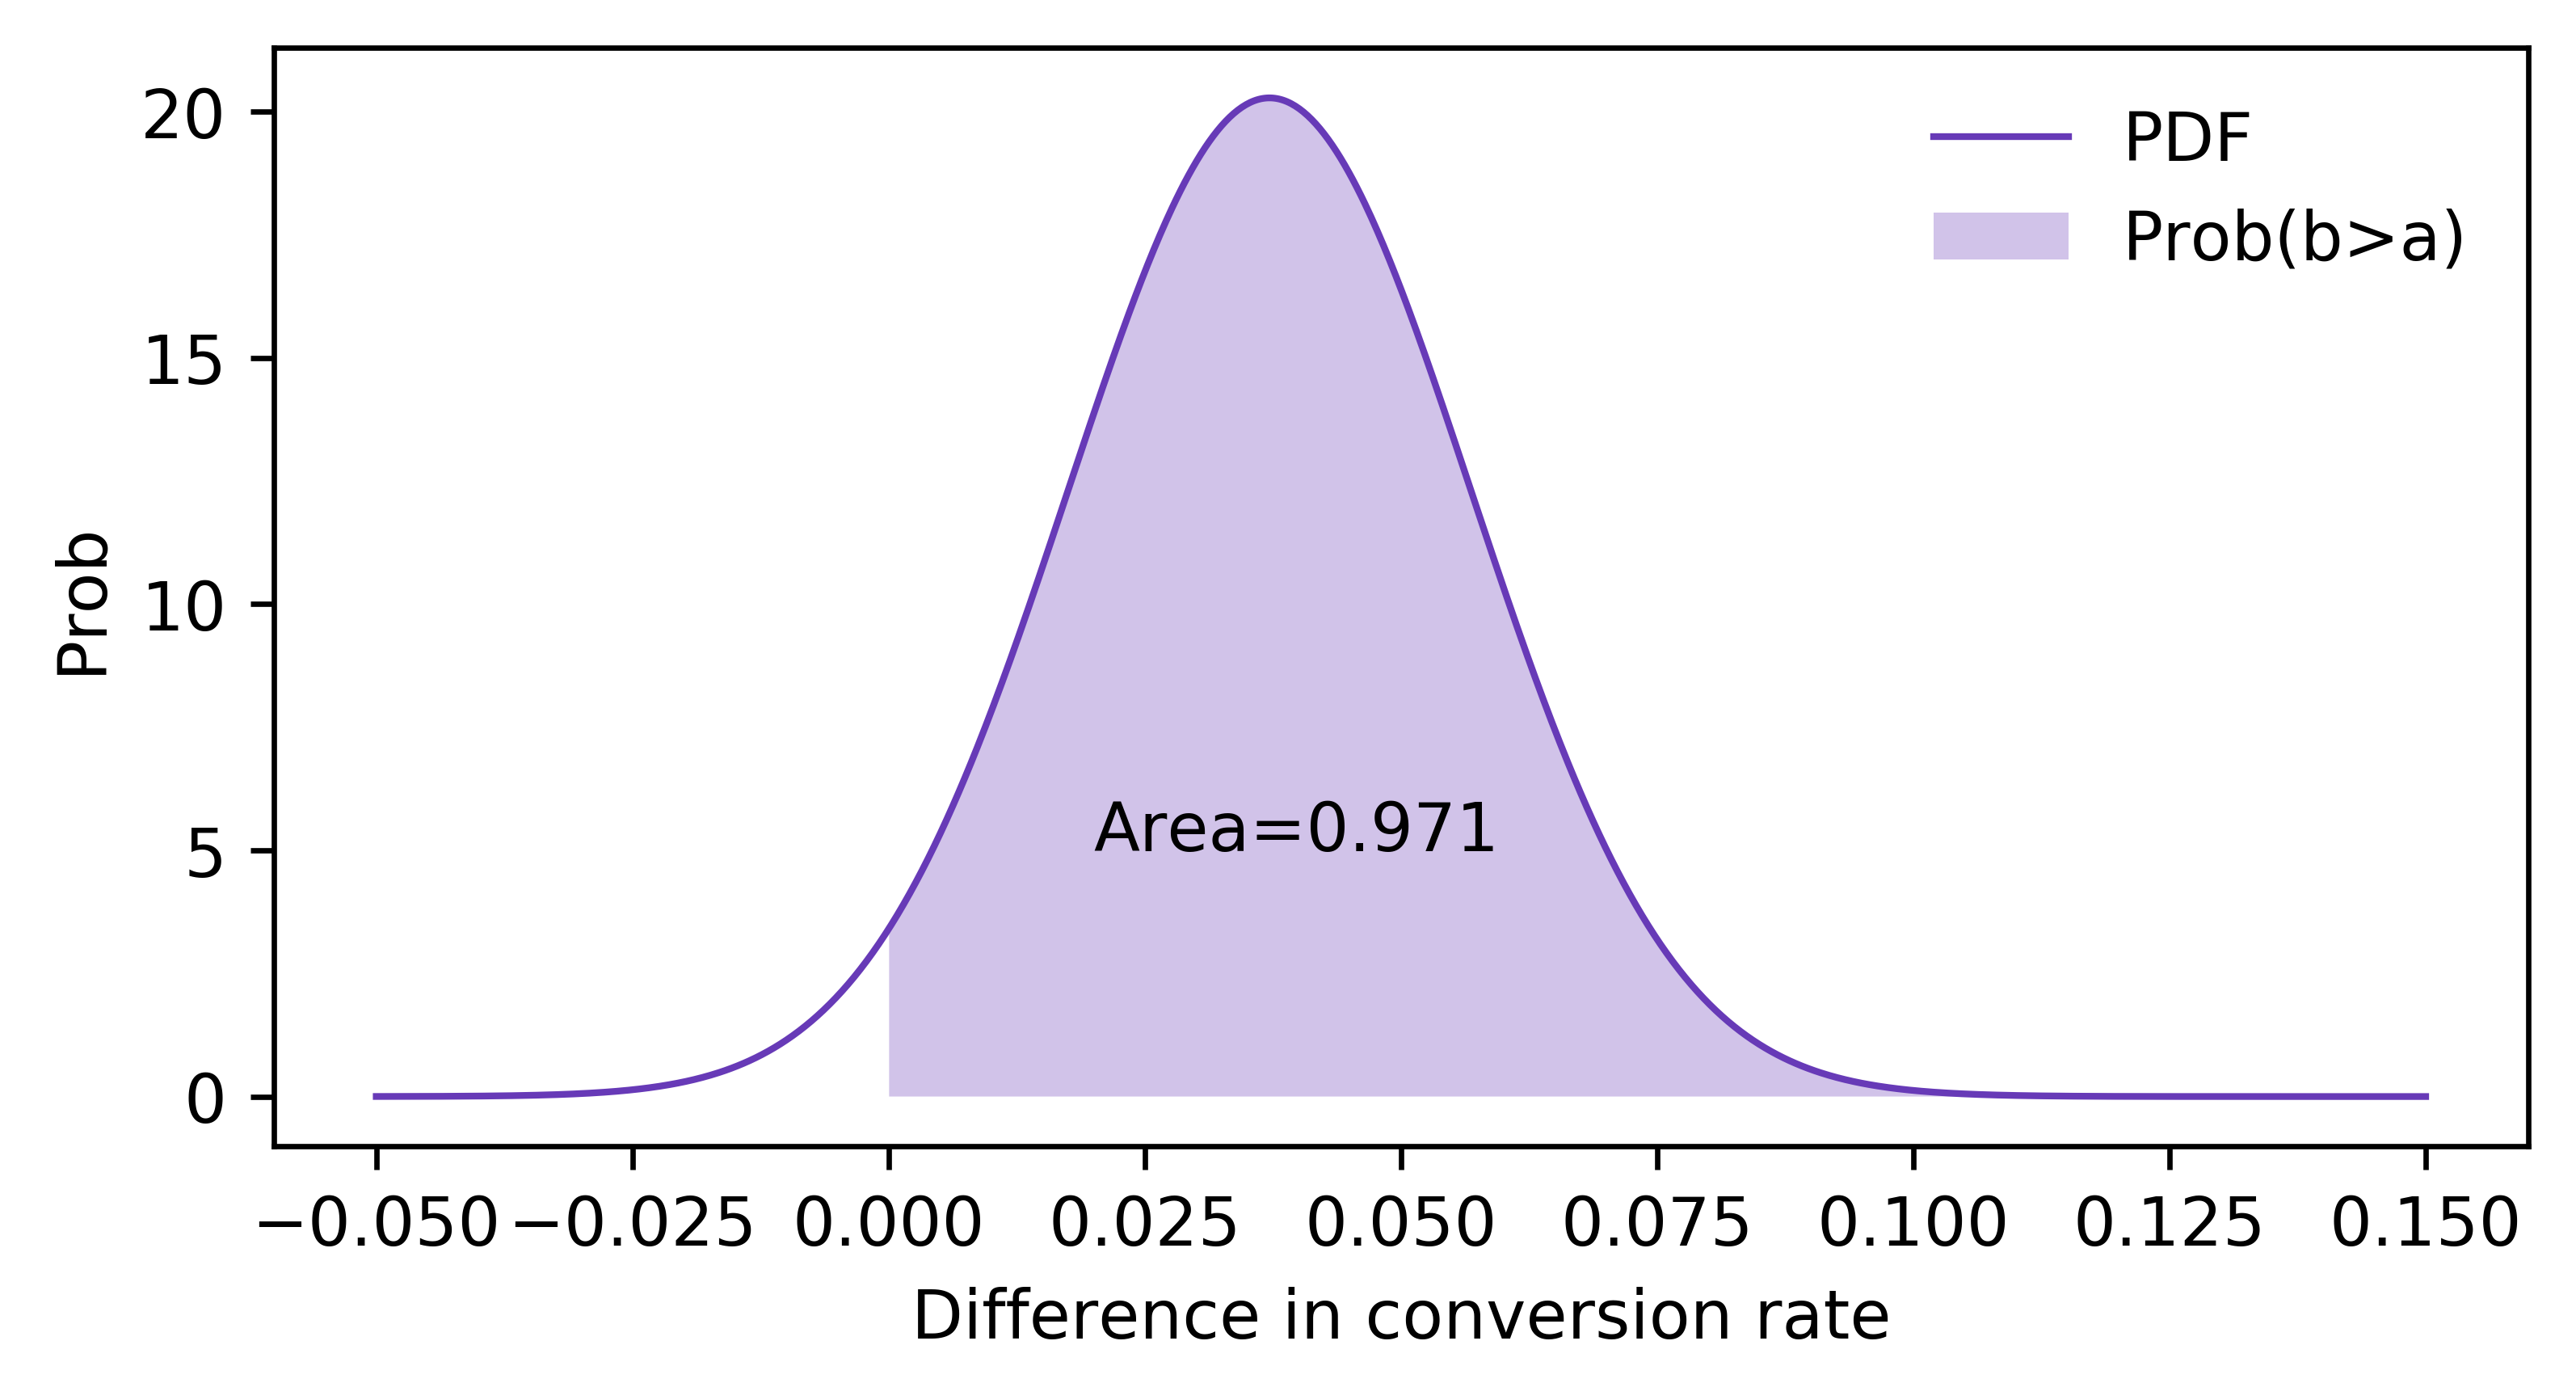

In [47]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with prob {norm().sf(z_score):0.3f}")

Great! So we are 97% confident that B is better than A. The p-value (chance this was a fluke) is only 0.029. 

However, we've made a lot of plots for this to try and explain the concept. You can easily write a tiny function to simplify all of this. Whether you want the confidence or the p-value just means changing the final `norm.cdf` to `norm.sf`.

In [50]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(click_a, num_a, click_b, num_b))

0.9705973498275782
